In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import scipy
import numpy as np
import os,sys

currentdir = Path.cwd()
sys.path.insert(0,str(currentdir)+'\\utils') 
import skseq.sequences.structured_perceptron as spc
import skseq

# Reproduce structured perceptron with our data

In [4]:
from utils import *
corpus = NerCorpus()

Load data and fill corpus.

In [5]:
data_path = "./data"

#data_path = parentdir + data_path

train_seq = corpus.read_sequence_list(data_path + "/train_data_ner.csv", 
                                            max_sent_len=100)

test_seq = corpus.read_sequence_list(data_path + "/test_data_ner.csv",
                                           max_sent_len=100)

tiny_test_seq = corpus.read_sequence_list(data_path + "/tiny_test.csv", 
                                          max_sent_len=100)

Create featrue mapper object.

In [17]:
feature_mapper = skseq.sequences.id_feature.IDFeatures(train_seq)
feature_mapper.build_features()

Import structured perceptron

In [18]:
import skseq.sequences.structured_perceptron as spc

sp = spc.StructuredPerceptron(corpus.word_dict, corpus.tag_dict, feature_mapper)
sp.num_epochs = 5

In [20]:
sp.get_num_states(), sp.get_num_observations()

(17, 54895)

In [21]:
feature_mapper.get_num_features()

39579

Train strcuture perceptron? (No me queda claro si está del todo bien probadlo pls)

In [39]:
%%time
num_epochs = 4
sp.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.953578
Epoch: 1 Accuracy: 0.955062
Epoch: 2 Accuracy: 0.956796
Epoch: 3 Accuracy: 0.957577
CPU times: total: 1h 4min 28s
Wall time: 1h 6min 15s


In [40]:
# Make predictions for the various sequences using the trained model.
pred_tiny_test  = sp.viterbi_decode_corpus(tiny_test_seq)

In [41]:
# Evaluate and print accuracies
eval_test = evaluate_corpus(tiny_test_seq.seq_list, pred_tiny_test)
print("SP -  Accuracy Tiny Test: %.3f"%(eval_test))

SP -  Accuracy Tiny Test: 0.865


# F1 score, Metrcis

In [37]:
from skseq.sequences.confusion_matrix import *

In [ ]:
tag_colors ={'O': 'Fuchsia',
             'B-geo': 'ForestGreen',
             'B-gpe': 'Blue',
             'B-tim': 'DarkGreen',
             'B-org': 'Khaki',
             'I-geo': 'Black',
             'B-per': 'LightGrey',
             'I-per': 'GreenYellow',
             'I-org': 'DarkGray',
             'B-art': 'Indigo',
             'I-art': 'DarkSeaGreen',
             'I-tim': 'Red',
             'I-gpe': '',
             'B-nat': '',
             'I-nat': '',
             'B-eve': '',
             'I-eve': ''}

In [34]:
corpus.tag_dict

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-tim': 3,
 'B-org': 4,
 'I-geo': 5,
 'B-per': 6,
 'I-per': 7,
 'I-org': 8,
 'B-art': 9,
 'I-art': 10,
 'I-tim': 11,
 'I-gpe': 12,
 'B-nat': 13,
 'I-nat': 14,
 'B-eve': 15,
 'I-eve': 16}

In [8]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def Evaluate_metrics(sequences, sequences_predictions, corpus):
    '''
        Returns ACC. and F1 with the requested requieremetns.
    '''
    def f1(y_true, y_pred):
        return f1_score(y_true, y_pred, average='weighted')

    y_true = np.concatenate([np.array(sequences[s].y) for s in range(len(sequences))])
    y_pred = np.concatenate([sequences_predictions[s].y for s in range(len(sequences_predictions))])
    
    mask = y_true!= corpus.tag_dict['O']
    y_pred_f = y_pred[mask]
    y_true_f = y_true[mask]
    # Acc. ignoring 'O', weighted f1, 
    return accuracy_score(y_true_f, y_pred_f), f1(y_true, y_pred)

In [122]:
Evaluate_metrics(tiny_test_seq.seq_list, pred_tiny_test, corpus)

(0.41379310344827586, 0.8423139558853844)

# Adding features

In [6]:
from skseq.sequences.extended_features import *

feature_mapper_ext = Extended_Features(train_seq)
feature_mapper_ext.build_features()

In [7]:
id_seq = 8
seq = train_seq[id_seq]
inv_feature_dict = {word: pos for pos, word in feature_mapper_ext.feature_dict.items()}
feature_type = ["Initial features", "Transition features", "Final features", "Emission features"]

def show_feats(feature_mapper, seq):
    for feat,feat_ids in enumerate(feature_mapper.get_sequence_features(seq)):
        print(feature_type[feat])
        for id_list in feat_ids:
            print ("\t",id_list)
            for k,id_val in enumerate(id_list):
                print ("\t\t", inv_feature_dict[id_val] )
        print("\n")

show_feats(feature_mapper_ext, seq)

Initial features
	 [0]
		 init_tag:O


Transition features
	 [22]
		 prev_tag:O::B-geo
	 [25]
		 prev_tag:B-geo::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [77]
		 prev_tag:O::B-org
	 [225]
		 prev_tag:B-org::I-org
	 [227]
		 prev_tag:I-org::O
	 [10]
		 prev_tag:O::O
	 [22]
		 prev_tag:O::B-geo
	 [95]
		 prev_tag:B-geo::I-geo
	 [96]
		 prev_tag:I-geo::O
	 [120]
		 prev_tag:O::B-per
	 [235]
		 prev_tag:B-per::O
	 [120]
		 prev_tag:O::B-per
	 [125]
		 prev_tag:B-per::I-per
	 [127]
		 prev_tag:I-per::O
	 [10]
		 prev_tag:O::O
	 [42]
		 prev_tag:O::B-gpe
	 [44]
		 prev_tag:B-gpe::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::O
	 [10]
		 prev_tag:O::

In [13]:
feature_mapper_ext.get_num_features()

40008

In [15]:
import skseq.sequences.structured_perceptron as spc

sp = spc.StructuredPerceptron(corpus.word_dict, corpus.tag_dict, feature_mapper_ext)
sp.num_epochs = 2
num_epochs = 2
sp.fit(feature_mapper_ext.dataset, num_epochs)

Epoch: 0 Accuracy: 0.929694
Epoch: 1 Accuracy: 0.943821


## Confsuion matrix

In [7]:
feature_mapper = skseq.sequences.id_feature.IDFeatures(train_seq)
feature_mapper.build_features()

sp = spc.StructuredPerceptron(corpus.word_dict, corpus.tag_dict, feature_mapper)
sp.load_model(dir="./fitted_models/perceptron_5_iter_given")

In [8]:
#pred_train = sp.viterbi_decode_corpus(train_seq)
#pred_test  = sp.viterbi_decode_corpus(test_seq)
pred_tiny_test  = sp.viterbi_decode_corpus(tiny_test_seq)

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_440\2203077748.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(class_names), rotation=45)
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_440\2203077748.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(class_names))


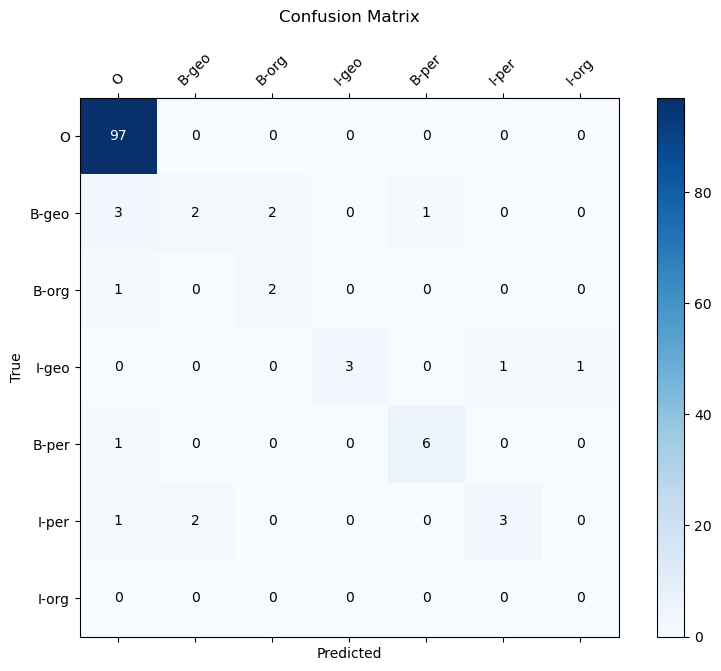

(0.5517241379310345, 0.8874678760393045)

In [30]:
def Evaluate_metrics(sequences, sequences_predictions, corpus, save=False, plotname=None):
    '''
        Returns ACC. and F1 with the requested requieremetns.
    '''
    def f1(y_true, y_pred):
        return f1_score(y_true, y_pred, average='weighted')

    y_true = np.concatenate([np.array(sequences[s].y) for s in range(len(sequences))])
    y_pred = np.concatenate([sequences_predictions[s].y for s in range(len(sequences_predictions))])
    
    mask = y_true!= corpus.tag_dict['O']
    y_pred_f = y_pred[mask]
    y_true_f = y_true[mask]

    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(10, 7))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', pad=20)
    fig.colorbar(cax)
    
    # Set axes labels and tick marks
    class_names  = np.array(list(corpus.tag_dict.keys()))[list(set(y_pred) | set(y_true))]
    ax.set_xticklabels([''] + list(class_names), rotation=45)
    ax.set_yticklabels([''] + list(class_names))
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Annotate each cell in the matrix with the numeric value
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")
    if save:
        plt.savefig(plotname)    
    plt.show()
    
    # Acc. ignoring 'O', weighted f1, 
    return accuracy_score(y_true_f, y_pred_f), f1(y_true, y_pred)

Evaluate_metrics(tiny_test_seq.seq_list, pred_tiny_test, corpus)